In [13]:
import numpy as np
import matplotlib.pyplot as plt
#from numba import njit
from time import time


N = 5
Dim = 3
#G = 4.3*10**(-6)
G = 4.3*10**(-1)
#G = 1
DT = 0.01
eps=0.0001

#R = np.random.rand(N,Dim)*2-1
#V = (np.random.rand(N,Dim)-0.5)
#M = np.random.rand(N,1)

def grav_force2(positions,masses):
    force_array = np.zeros((N,Dim))
    for i in range(N):
        for j in range(i):
            r_ij = positions[i]-positions[j]
            force_ij = -G*masses[i]*masses[j]*(r_ij)/(np.dot(r_ij,r_ij)**(1.5))
            force_array[i] += force_ij
            force_array[j] += -force_ij

    return force_array


def grav_acceleration3(r_array,m_array):
    n = len(m_array)
    r_ij_matrix = np.empty((n,n,3))
    force_ij_matrix = np.empty((n,n,3))

    r_ij_matrix[:,:,0]=r_array[:,0]-r_array[:,0].reshape(n,1)
    r_ij_matrix[:,:,1]=r_array[:,1]-r_array[:,1].reshape(n,1)
    r_ij_matrix[:,:,2]=r_array[:,2]-r_array[:,2].reshape(n,1)

    r_mag_sq_array = r_ij_matrix[:,:,0]**2 + r_ij_matrix[:,:,1]**2 + r_ij_matrix[:,:,2]**2

    force_ij_matrix[:,:,0] = -G*(r_ij_matrix[:,:,0])/((r_mag_sq_array+eps)**(1.5))*m_array.reshape(n,1)
    force_ij_matrix[:,:,1] = -G*(r_ij_matrix[:,:,1])/((r_mag_sq_array+eps)**(1.5))*m_array.reshape(n,1)
    force_ij_matrix[:,:,2] = -G*(r_ij_matrix[:,:,2])/((r_mag_sq_array+eps)**(1.5))*m_array.reshape(n,1)

    acceleration_array = np.sum(force_ij_matrix,axis=0)

    return acceleration_array

def grav_acceleration(positions,masses):
    n = len(masses)
    force_array = np.zeros((n,Dim))
    for i in range(n):
        for j in range(i):
            r_ij = positions[i]-positions[j]
            force_ij = -G*(r_ij)/((np.dot(r_ij,r_ij)+eps)**(1.5))
            force_array[i] += force_ij*masses[j]
            force_array[j] += -force_ij*masses[i]

    return force_array

def apply_force2(initial_r, masses, initial_v, iterations):
    r_array = np.empty((iterations,N,Dim))
    v_array_p05 = np.empty((iterations,N,Dim))
    r_array[0] = initial_r
    acceleration = grav_acceleration(r_array[0],masses)
    v_array_p05[0] = initial_v + acceleration*DT/2
    r_array[1] = r_array[0] + v_array_p05[0]*DT# + 0.5*acceleration*DT**2
    for i in range(1,iterations-1):
        acceleration = grav_acceleration(r_array[i],masses)
        v_array_p05[i] = v_array_p05[i-1] + acceleration*DT
        r_array[i+1] = r_array[i] + v_array_p05[i]*DT

    return r_array, v_array_p05

def apply_force4(initial_r, masses, initial_v, iterations):
    r_array = np.empty((iterations,N,Dim))
    v_array_p05 = np.empty((iterations,N,Dim))
    r_array[0] = initial_r
    acceleration = grav_acceleration3(r_array[0],masses)
    v_array_p05[0] = initial_v + acceleration*DT/2
    r_array[1] = r_array[0] + v_array_p05[0]*DT# + 0.5*acceleration*DT**2
    for i in range(1,iterations-1):
        acceleration = grav_acceleration3(r_array[i],masses)
        v_array_p05[i] = v_array_p05[i-1] + acceleration*DT
        r_array[i+1] = r_array[i] + v_array_p05[i]*DT

    return r_array, v_array_p05

def grav_potential(positions,masses):
    potential_array = np.zeros((N,1))
    for i in range(N):
        for j in range(i):
            r_ij = positions[i]-positions[j]
            potential_ij = -G*masses[i]*masses[j]/(np.sqrt(np.dot(r_ij,r_ij)))
            potential_array[i] += potential_ij
            potential_array[j] += potential_ij
    return potential_array

def apply_force3(initial_r, masses, initial_v, iterations):
    initial_energy = grav_potential(initial_r,masses)[:,0]
    initial_energy += 0.5*masses[:,0]*np.sum(initial_v**2,1)
    r_array = np.empty((iterations,N,Dim))
    v_array_p05 = np.empty((iterations,N,Dim))
    
    r_array[0] = initial_r
    acceleration = grav_acceleration(r_array[0],masses)
    v_array_p05[0] = initial_v + acceleration*DT/2
    r_array[1] = r_array[0] + v_array_p05[0]*DT# + 0.5*acceleration*DT**2
    for i in range(1,iterations-1):
        acceleration = grav_acceleration(r_array[i],masses)
        v_array_p05[i] = v_array_p05[i-1] + acceleration*DT
        r_array[i+1] = r_array[i] + v_array_p05[i]*DT

    acceleration = grav_acceleration(r_array[-1],masses)
    v_array_p05[-1] = v_array_p05[-2] + acceleration*DT
    final_v = v_array_p05[-1]
    final_r = r_array[-1] + (v_array_p05[-2]+v_array_p05[-1])*DT/4 + acceleration*DT**2/8
    final_energy = grav_potential(final_r,masses)[:,0]
    final_energy += 0.5*masses[:,0]*np.sum(final_v**2,1)
    energy = (initial_energy,final_energy)
    return r_array, v_array_p05, energy

In [ ]:
print('Iterations = 100\nN\ttime')

for n in range(2,3,5):
    N = n
    t1 = time()
    R = np.random.rand(N,Dim)*2-1
    V = (np.random.rand(N,Dim)-0.5)
    M = np.random.rand(N,1)

    r_hist,v_hist = apply_force2(R,M,V,100)
    t2 = time()
    print(f'{N}\t{t2-t1:.3e}')

Iterations = 100
N	time
2	7.632e-03


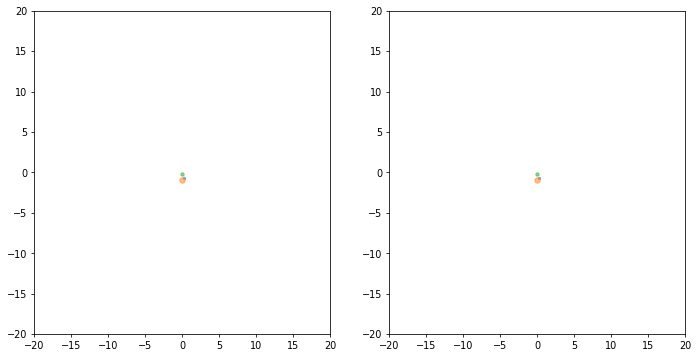

In [ ]:
#Animación de ambos algoritmos en paralelo
import matplotlib.animation as animation


N = 3
R = np.random.rand(N,Dim)*2-1
V = (np.random.rand(N,Dim)-0.5)
M = np.random.rand(N,1)
FRAMES = 500
IPF = 20 #Iterations per frame
ITERATIONS = FRAMES*IPF

r_for,v_for = apply_force2(R,M,V,ITERATIONS)
r_numpy,v_numpy = apply_force4(R,M,V,ITERATIONS)

fig, ax = plt.subplots(1,2,figsize=(12,6),dpi=70)

ax[0].set_xlim(-20,20)
ax[0].set_ylim(-20,20)
ax[1].set_xlim(-20,20)
ax[1].set_ylim(-20,20)

for_dot = []
for_line = []
numpy_dot = []
numpy_line = []

for n in range(N):
  #ax.scatter(r_for[0,n,0],r_for[0,n,1])
  #ax.scatter(r_numpy[0,n,0],r_numpy[0,n,1])
#  for_dot[n] = plt.scatter(r_for[0,n,0],r_for[0,n,1])
#  for_line[n] = plt.plot(r_for[0,n,0],r_for[0,n,1])
#  numpy_dot[n] = plt.scatter(r_numpy[0,n,0],r_numpy[0,n,1])
#  numpy_line[n] = plt.plot(r_numpy[0,n,0],r_numpy[0,n,1])
  for_dot.append(ax[0].scatter(r_for[0,n,0],r_for[0,n,1],s=M[n]*50,alpha=0.5))
  for_line.append(ax[0].plot(r_for[0,n,0],r_for[0,n,1])[0])
  numpy_dot.append(ax[1].scatter(r_numpy[0,n,0],r_numpy[0,n,1],s=M[n]*50,alpha=0.5))
  numpy_line.append(ax[1].plot(r_numpy[0,n,0],r_numpy[0,n,1])[0])


#Se crea una función que cambia los datos necesarios en cada frame
def animate(i):
    it = i*IPF
    for n in range(N):
    #for_dot.set_xdata(r_for[it,n,0])
    #for_dot.set_ydata(r_for[it,n,1])
      for_line[n].set_data(r_for[:it,n,0],r_for[:it,n,1])
    #numpy_dot.set_data(r_numpy[it,n,0],r_numpy[it,n,1])
      numpy_line[n].set_data(r_numpy[:it,n,0],r_numpy[:it,n,1])
    return for_dot, for_line, numpy_dot, numpy_line

  #Se crea la animación
anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                interval=20, repeat_delay=3000)

anim.save('test.gif',writer='pillow')
